In [1]:
!pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 4.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 93.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-fft 1.3.10 requires mkl, which is not installed.
hdijupyterutils 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.1 which is incompatible.
sagemaker 2.229.0 requires numpy<2.0,>=1.9.0, but you have numpy 2.1.1 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.2

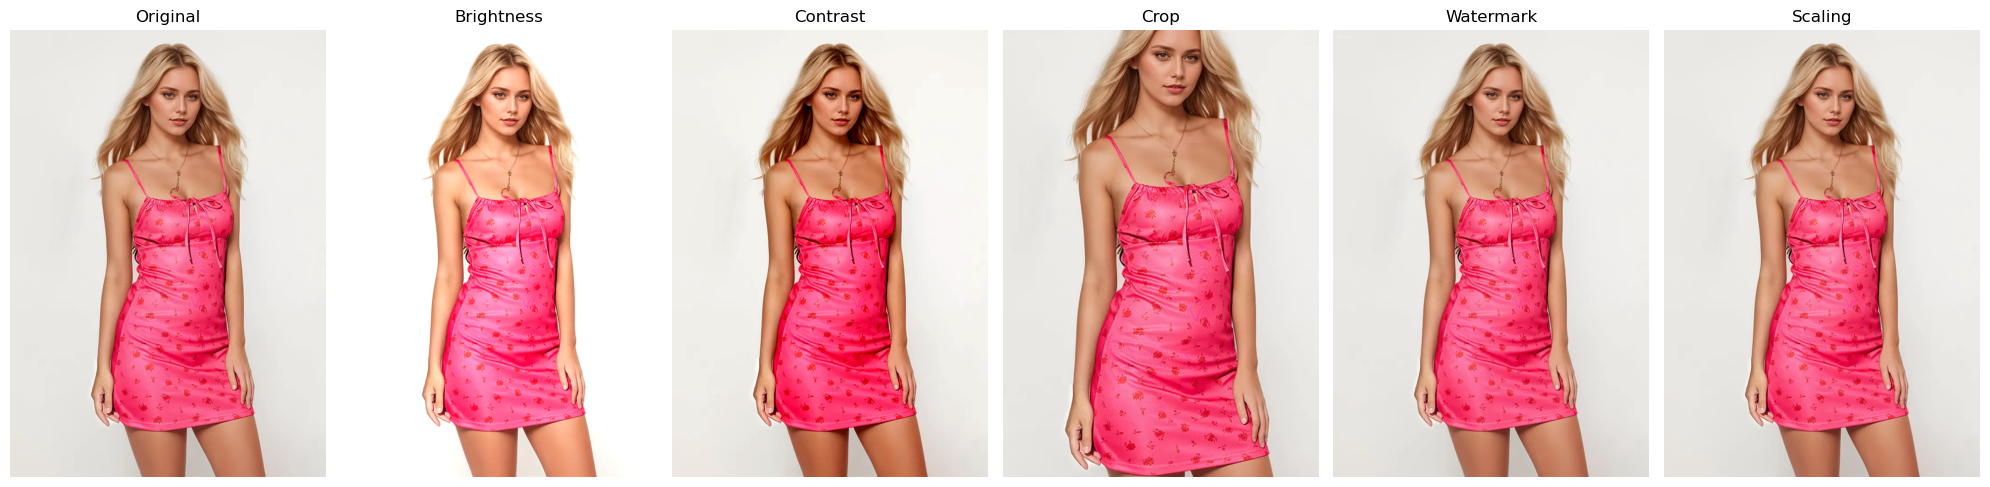

In [14]:
import pandas as pd
import imagehash
from PIL import Image, ImageEnhance, ImageOps, ImageDraw
import matplotlib.pyplot as plt
import aiohttp
import asyncio
from io import BytesIO

def apply_brightness(img):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(1.2)  # Increase brightness by 20%

def apply_contrast(img):
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(1.2)  # Increase contrast by 20%

def apply_crop(img):
    width, height = img.size
    crop_percent = 0.1  # Crop 10% from each side
    crop_area = (
        int(width * crop_percent), 
        int(height * crop_percent),
        int(width * (1 - crop_percent)), 
        int(height * (1 - crop_percent))
    )
    return img.crop(crop_area)

def apply_watermark(img):
    watermark_text = Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(watermark_text)
    draw.text((10, 10), 'Sample', fill=(255, 255, 255, 128))
    img = img.convert("RGBA")
    return Image.alpha_composite(img, watermark_text).convert("RGB")

def apply_scaling(img):
    new_size = (int(img.size[0] * 0.), int(img.size[1] * 0.5))  # Scale down by 10%
    return img.resize(new_size, Image.Resampling.LANCZOS)

modification_functions = {
    'Original': lambda img: img,  # no modification
    'Brightness': apply_brightness,
    'Contrast': apply_contrast,
    'Crop': apply_crop,
    'Watermark': apply_watermark,
    'Scaling': apply_scaling
}

async def fetch_image(session, url):
    async with session.get(url) as response:
        if response.status == 200:
            img_data = await response.read()
            return Image.open(BytesIO(img_data)).convert('RGB')
        else:
            raise IOError(f"Failed to fetch image from {url}, status code: {response.status}")

# effects of each modification
async def show_modifications(sample_image_url):
    async with aiohttp.ClientSession() as session:
        try:
            img = await fetch_image(session, sample_image_url)

            fig, axes = plt.subplots(1, len(modification_functions), figsize=(20, 5))
            axes = axes.flatten()

            for ax, (mod_name, mod_func) in zip(axes, modification_functions.items()):
                modified_img = mod_func(img)
                ax.imshow(modified_img)
                ax.set_title(mod_name)
                ax.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Failed to process image at {sample_image_url}: {e}")

base_url = "https://d1it09c4puycyh.cloudfront.net"
resolution = "707x1000"
sample_image_path = "/P/G/PG3205-PINK_1.jpg"  # example path from CSV
sample_image_url = f"{base_url}/{resolution}/catalog/product{sample_image_path.strip()}"

await show_modifications(sample_image_url)


In [16]:
async def fetch_image(session, url):
    async with session.get(url) as response:
        if response.status == 200:
            img_data = await response.read()
            return Image.open(BytesIO(img_data)).convert('RGB')
        else:
            raise IOError(f"Failed to fetch image from {url}, status code: {response.status}")

def calculate_phash(img):
    long_side = max(img.size)
    ratio = 512 / long_side
    new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
    img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    new_img = Image.new('RGB', (512, 512), (255, 255, 255))
    paste_pos = ((512 - new_size[0]) // 2, (512 - new_size[1]) // 2)
    new_img.paste(img, paste_pos)
    
    return imagehash.phash(new_img)

async def process_image(session, row, pbar):
    base_url = "https://d1it09c4puycyh.cloudfront.net"
    resolution = "707x1000"
    image_url = f"{base_url}/{resolution}/catalog/product{row['small_image'].strip()}"

    try:
        img = await fetch_image(session, image_url)
        
        original_phash = calculate_phash(img)

        results = {'entity_id': row['entity_id'], 'sku': row['sku']}
        for mod_name, mod_func in modification_functions.items():
            modified_img = mod_func(img)
            modified_phash = calculate_phash(modified_img)
            similarity = 1 - (original_phash - modified_phash) / 64.0
            results[f'similarity_{mod_name}'] = similarity

        pbar.update(1)
        return results

    except Exception as e:
        print(f"Failed to process image at {image_url}: {e}")
        pbar.update(1)
        return None

async def process_sample(sample_df):
    async with aiohttp.ClientSession() as session:
        pbar = tqdm(total=len(sample_df), desc="Processing Images")
        tasks = [process_image(session, row, pbar) for _, row in sample_df.iterrows()]
        results = await asyncio.gather(*tasks)
        pbar.close()
    return results

# main execution
df = pd.read_csv('image_data.csv')
df = df.dropna(subset=['small_image'])

sample_size = 100
sample_df = df.sample(n=sample_size, random_state=42)

results = await process_sample(sample_df)

results_df = pd.DataFrame([r for r in results if r])

print(results_df)

modification_columns = [col for col in results_df.columns if col.startswith('similarity_')]
similarity_matrix = results_df[modification_columns].mean().to_frame().T
similarity_matrix.index = ['Average Similarity']
print(similarity_matrix)

results_df.to_csv('hash_similarity_with_modifications_separate.csv', index=False)
similarity_matrix.to_csv('modification_summary_matrix.csv')


Processing Images:   0%|          | 0/100 [00:00<?, ?it/s]

    entity_id                     sku  similarity_Original  \
0      228227         K22D23096-BLACK                  1.0   
1      283188            STY-7755-RED                  1.0   
2      344604  XINCHUANGYI23626-BLACK                  1.0   
3      401014         QI-H-9129-GREEN                  1.0   
4      345760           JC-9712-BLACK                  1.0   
..        ...                     ...                  ...   
95     343206              1570-KHAKI                  1.0   
96     276699                   TVC44                  1.0   
97     300214         XCWQ-8777-BROWN                  1.0   
98     289714            FWP-ER-02-PL                  1.0   
99     392312            HK7017-GREEN                  1.0   

    similarity_Brightness  similarity_Contrast  similarity_Crop  \
0                 1.00000              0.96875          0.78125   
1                 0.96875              1.00000          0.65625   
2                 0.96875              0.93750        

Failed to process image at https://d1it09c4puycyh.cloudfront.net/707x1000/catalog/product/1/5/15555-BLUE_1.jpg: Server disconnected
Failed to process image at https://d1it09c4puycyh.cloudfront.net/707x1000/catalog/product/8/9/89PCIRISGOLD__1_.jpg: Server disconnected
Failed to process image at https://d1it09c4puycyh.cloudfront.net/707x1000/catalog/product/8/9/89JM-6900-KHAKI__1_.jpeg: Server disconnected
Failed to process image at https://d1it09c4puycyh.cloudfront.net/707x1000/catalog/product/1/5/1570-KHAKI_1.jpg: Server disconnected
Failed to process image at https://d1it09c4puycyh.cloudfront.net/707x1000/catalog/product/8/9/8907884930268_1.jpg: Server disconnected
Failed to process image at https://d1it09c4puycyh.cloudfront.net/707x1000/catalog/product/H/K/HK7017-GREEN_1.jpg: Server disconnected
Failed to process image at https://d1it09c4puycyh.cloudfront.net/707x1000/catalog/product/8/9/89TVC44_1.JPG: Server disconnected
Failed to process image at https://d1it09c4puycyh.cloudfront.n

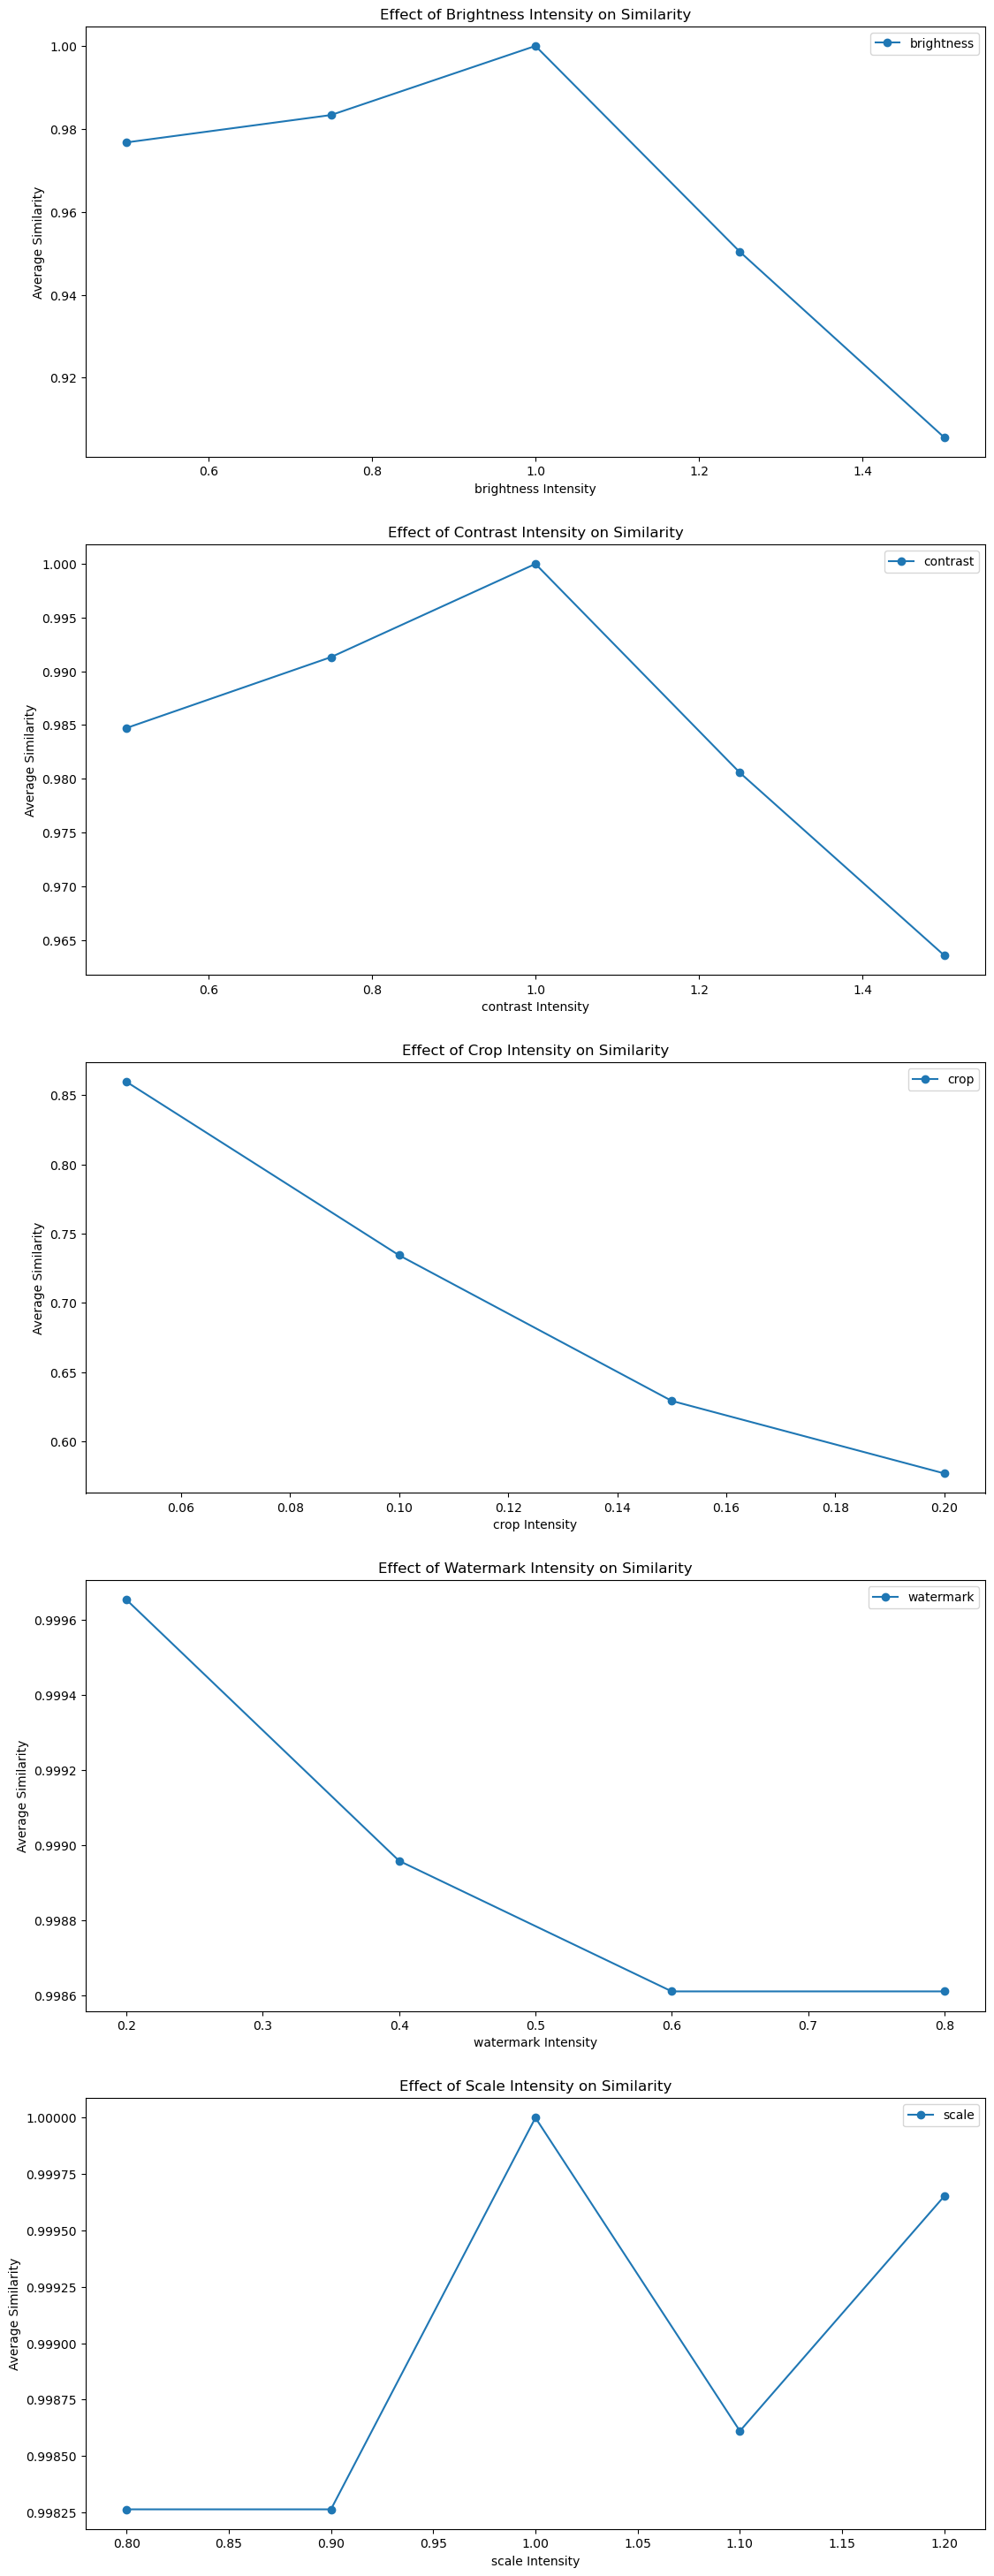

In [17]:
import pandas as pd
import imagehash
from PIL import Image, ImageEnhance, ImageOps, ImageDraw
import aiohttp
import asyncio
from io import BytesIO
from tqdm.asyncio import tqdm as async_tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Function to apply modifications with varying intensities
def apply_brightness(img, factor):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

def apply_contrast(img, factor):
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(factor)

def apply_crop(img, percent):
    width, height = img.size
    crop_area = (
        int(width * percent), 
        int(height * percent),
        int(width * (1 - percent)), 
        int(height * (1 - percent))
    )
    return img.crop(crop_area)

def apply_watermark(img, opacity):
    watermark_text = Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(watermark_text)
    draw.text((10, 10), 'Sample', fill=(255, 255, 255, int(opacity * 255)))
    img = img.convert("RGBA")
    return Image.alpha_composite(img, watermark_text).convert("RGB")

def apply_scaling(img, scale):
    new_size = (int(img.size[0] * scale), int(img.size[1] * scale))
    return img.resize(new_size, Image.Resampling.LANCZOS)

modification_functions = {
    'brightness': lambda img, factor: apply_brightness(img, factor),
    'contrast': lambda img, factor: apply_contrast(img, factor),
    'crop': lambda img, percent: apply_crop(img, percent),
    'watermark': lambda img, opacity: apply_watermark(img, opacity),
    'scale': lambda img, scale: apply_scaling(img, scale)
}

async def fetch_image(session, url):
    async with session.get(url) as response:
        if response.status == 200:
            img_data = await response.read()
            return Image.open(BytesIO(img_data)).convert('RGB')
        else:
            raise IOError(f"Failed to fetch image from {url}, status code: {response.status}")

def calculate_phash(img):
    long_side = max(img.size)
    ratio = 512 / long_side
    new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
    img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    new_img = Image.new('RGB', (512, 512), (255, 255, 255))
    paste_pos = ((512 - new_size[0]) // 2, (512 - new_size[1]) // 2)
    new_img.paste(img, paste_pos)
    
    return imagehash.phash(new_img)

async def process_image(session, row, intensities):
    base_url = "https://d1it09c4puycyh.cloudfront.net"
    resolution = "707x1000"
    image_url = f"{base_url}/{resolution}/catalog/product{row['small_image'].strip()}"
    
    try:
        img = await fetch_image(session, image_url)
        original_phash = calculate_phash(img)
        
        results = {'entity_id': row['entity_id'], 'sku': row['sku']}
        for mod_name, values in intensities.items():
            for value in values:
                mod_func = modification_functions[mod_name]
                modified_img = mod_func(img, value)
                modified_phash = calculate_phash(modified_img)
                similarity = 1 - (original_phash - modified_phash) / 64.0
                results[f'similarity_{mod_name}_{value}'] = similarity
                
        return results

    except Exception as e:
        print(f"Failed to process image at {image_url}: {e}")
        return None

async def process_sample(sample_df, intensities):
    async with aiohttp.ClientSession() as session:
        tasks = [process_image(session, row, intensities) for _, row in sample_df.iterrows()]
        results = await asyncio.gather(*tasks)
    return results

# main execution
df = pd.read_csv('image_data.csv')
df = df.dropna(subset=['small_image'])

sample_size = 100
sample_df = df.sample(n=sample_size, random_state=42)

intensities = {
    'brightness': np.linspace(0.5, 1.5, 5),
    'contrast': np.linspace(0.5, 1.5, 5),
    'crop': np.linspace(0.05, 0.20, 4),
    'watermark': np.linspace(0.2, 0.8, 4),
    'scale': np.linspace(0.8, 1.2, 5)
}

results = await process_sample(sample_df, intensities)

results_df = pd.DataFrame([r for r in results if r])

fig, axes = plt.subplots(len(intensities), 1, figsize=(12, 6 * len(intensities)))
fig.tight_layout(pad=5.0)

for ax, (mod_name, values) in zip(axes, intensities.items()):
    similarity_cols = [col for col in results_df.columns if col.startswith(f'similarity_{mod_name}_')]
    mean_similarities = results_df[similarity_cols].mean()
    
    intensities_values = [float(col.split('_')[-1]) for col in similarity_cols]
    ax.plot(intensities_values, mean_similarities, marker='o', linestyle='-', label=mod_name)
    ax.set_xlabel(f'{mod_name} Intensity')
    ax.set_ylabel('Average Similarity')
    ax.set_title(f'Effect of {mod_name.capitalize()} Intensity on Similarity')
    ax.legend()

plt.show()

results_df.to_csv('hash_similarity_with_varying_intensities.csv', index=False)
